# Bluesky Data Collection Framework

Callum Forrester

## Bluesky

- Family of software libraries developed by NSLS-II in Brookhaven, New York, USA.
- Confusingly, also the name of one of those libraries!
- Analysis-first data collection
- Aimed at making it easy to programatically make a beamline produce diverse data/metadata to suit diverse analysis needs
- Managed by a newly appointed technical steering committe

<img src="img/logo-bluesky.png" width="500"/>

## NSLS-II
- Operational since 2015
- Storage ring nearly 800m in circumference
- 58 Beamlines planned

<img src="img/nsls2.png" width="500"/>

## Diamond Almost Fits Inside...

<img src="img/nsls2-dls.png" width="500"/>

## Bread & Butter of Data Collection

- Control environment with actuators, record data with sensors/detectors
- Classic example, move sample through beam with motors, take pictures of interfered beam with detector:

<img src="img/scanning.svg" width="1000"/>
<img src="img/graph.svg" width="500"/>

## Beamline Software Stack

<img src="img/stack.svg" width="800"/>

## A Good DCS Should be...

- Versatile
    - Produce a wide variety of data
    - Perform modular tasks that can be composed in different ways, no two experiments are the same
- Scriptable in a scientist-friendly way
    - Python
    - Minimal boilerplate
    - Balance of simplicity and expressiveness: beamlines are complicated
- Balance of stability and innovation
    - Provide common, plug-and-play functionality where possible
    - Easy to write bespoke functionality where necessary
    - Innovation happens in-situ, but also need a stable platform to fall back to to satify user demand
    - Spectrum of users, some want a library, some want a big button that says go:

<img src="img/spectrum.svg" width="500"/>
    

## Bluesky

- Collection of components
- Loosely coupled
- Python libraries
- Friendly to people who know the Python scientific ecosystem, numpy, scipy etc.

<img src="img/bluesky.png" width="800"/>

- Building blocks:
    - Devices: Python abstractions of motors, detectors, etc.
    - Plans: Instructions for sequencing complex actions
    - Run Engine: Control object for running plans
    - Events: Descriptions of data recorded, emitted by run engine

## Devices

- Defined interfaces
    - `Readable`
    - `Movable`
    - `Flyable`
    - `Stageable`
    - `Checkable`
- Can have any device library that follows these interfaces
- NSLS-II have one called Ophyd (EPICS focused), there is nothing to stop you from writing your own

In [1]:
from ophyd.sim import SynAxis, Syn2DGauss

x = SynAxis(name="x", delay=0.1)
y = SynAxis(name="y", delay=0.1)
det = Syn2DGauss(
    "det",
    x,
    "x",
    y,
    "y",
    center=(0, 0),
    Imax=1,
    labels={"detectors"},
)


In [2]:
print(f"x and y are at ({x.position}, {y.position})")

x.set(x.position + 10).wait()
y.set(y.position + 5).wait()

print(f"x and y are now at ({x.position}, {y.position})")

x and y are at (0, 0)
x and y are now at (10, 5)


## Plans

- Iterable sequence of messages, instructions on what the beamline should do and what data should be recorded
- The following are all valid plans:

In [3]:
from typing import Iterable
from bluesky.utils import Msg


# Empty plan:
[]

# Plan with two messages:
[Msg("open_run"), Msg("close_run")]

# Dyanmic plan
def my_plan() -> Iterable[Msg]:
    yield Msg("open_run")
    if 3 < 4:
        yield Msg("checkpoint")
    yield Msg("close_run")

list(my_plan())

[Msg('open_run', obj=None, args=(), kwargs={}, run=None),
 Msg('checkpoint', obj=None, args=(), kwargs={}, run=None),
 Msg('close_run', obj=None, args=(), kwargs={}, run=None)]

In [11]:
import bluesky.plan_stubs as bps
import bluesky.plans as bp

from bluesky import RunEngine

print(f"x is at {x.position}")

RE = RunEngine()
RE(bps.mvr(x, 10))

print(f"x is at {x.position}")

x is at 30.0
x is at 40.0


In [13]:
RE(bp.count([det]))

('68fc4f47-ce4c-4af1-a43b-f87b8aa06a93',)

## Events

- Emitted when data recorded
- Structured into "runs" 
- Can reference big data rather than store directly!

In [4]:
from typing import Dict

import bluesky.plan_stubs as bps
import bluesky.plans as bp

from bluesky import RunEngine
from pprint import pprint

def print_event(name: str, doc: Dict) -> None:
    pprint({name: doc})

RE(bp.count([det]), print_event)

{'start': {'detectors': ['det'],
           'hints': {'dimensions': [(('time',), 'primary')]},
           'num_intervals': 0,
           'num_points': 1,
           'plan_args': {'detectors': ["Syn2DGauss(prefix='', name='det', "
                                       "read_attrs=['val'], "
                                       "configuration_attrs=['Imax', 'center', "
                                       "'sigma', 'noise', "
                                       "'noise_multiplier'])"],
                         'num': 1},
           'plan_name': 'count',
           'plan_type': 'generator',
           'scan_id': 1,
           'time': 1664809307.2600493,
           'uid': '72a73197-156e-4586-a17d-794c5320e3c7',
           'versions': {'bluesky': '1.10.0', 'ophyd': '1.7.0'}}}
{'descriptor': {'configuration': {'det': {'data': {'det_Imax': 1,
                                                   'det_center': (0, 0),
                                                   'det_noise': 'none',

('72a73197-156e-4586-a17d-794c5320e3c7',)

## Scanning

- Change some variables, read other variables
- Sample many points



Transient Scan ID: 2     Time: 2022-10-03 16:01:48
Persistent Unique Scan ID: '26ad00be-ef74-4386-91a3-8fe2d82a2c99'
New stream: 'primary'


<IPython.core.display.Javascript object>


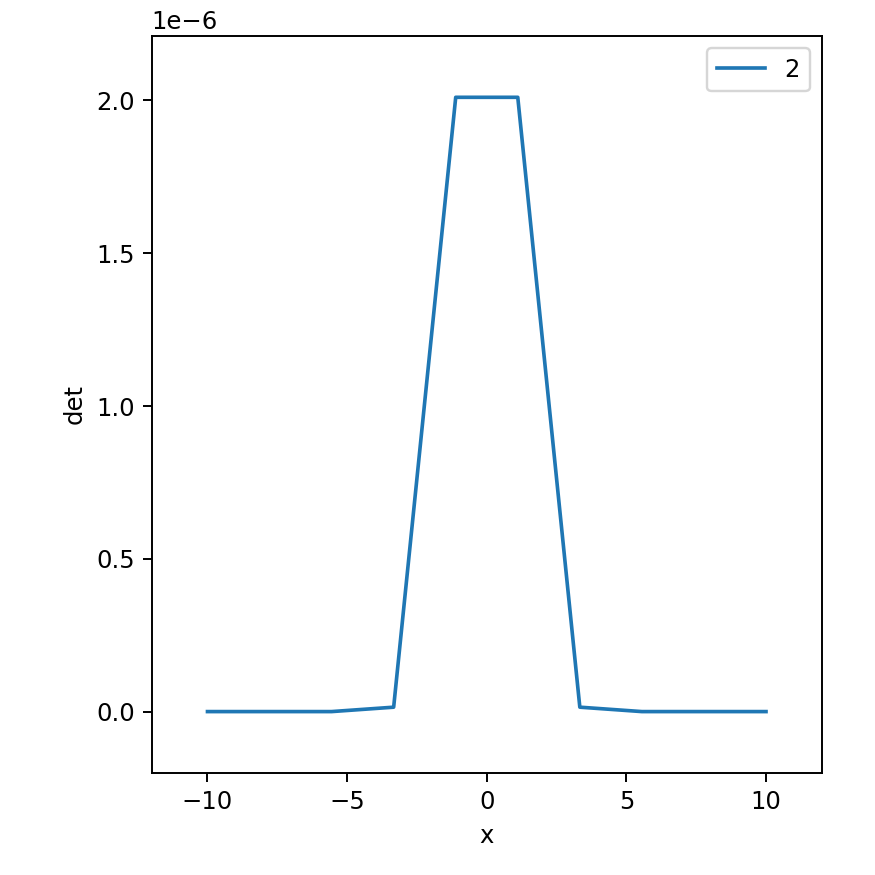

+-----------+------------+------------+------------+
|   seq_num |       time |          x |        det |
+-----------+------------+------------+------------+
|         1 | 16:01:48.6 |    -10.000 |      0.000 |
|         2 | 16:01:48.8 |     -7.778 |      0.000 |
|         3 | 16:01:48.9 |     -5.556 |      0.000 |
|         4 | 16:01:49.0 |     -3.333 |      0.000 |
|         5 | 16:01:49.1 |     -1.111 |      0.000 |
|         6 | 16:01:49.2 |      1.111 |      0.000 |
|         7 | 16:01:49.3 |      3.333 |      0.000 |
|         8 | 16:01:49.4 |      5.556 |      0.000 |
|         9 | 16:01:49.5 |      7.778 |      0.000 |
|        10 | 16:01:49.6 |     10.000 |      0.000 |
+-----------+------------+------------+------------+
generator scan ['26ad00be'] (scan num: 2)





('26ad00be-ef74-4386-91a3-8fe2d82a2c99',)

In [5]:
%matplotlib notebook 

from bluesky.callbacks.best_effort import BestEffortCallback

RE(bp.scan([det], x, -10, 10, 10), BestEffortCallback())

## Adaptive Plans and Automation

- Plans can be made to react to measurement results or changes in environment
- Potential use for creating complicated, bespoke workflows
- Interesting potential for beamline automation
- MX particularly interested in this

https://github.com/DiamondLightSource/python-artemis


In [6]:
import time
from math import sin
from ophyd.sim import SynPeriodicSignal

# Create simulated temperature readout
def sine_temp() -> float:
    return sin(time.time()) * 10 + 15

temperature = SynPeriodicSignal(sine_temp, name="temperature")
temperature.start_simulation()

<IPython.core.display.Javascript object>


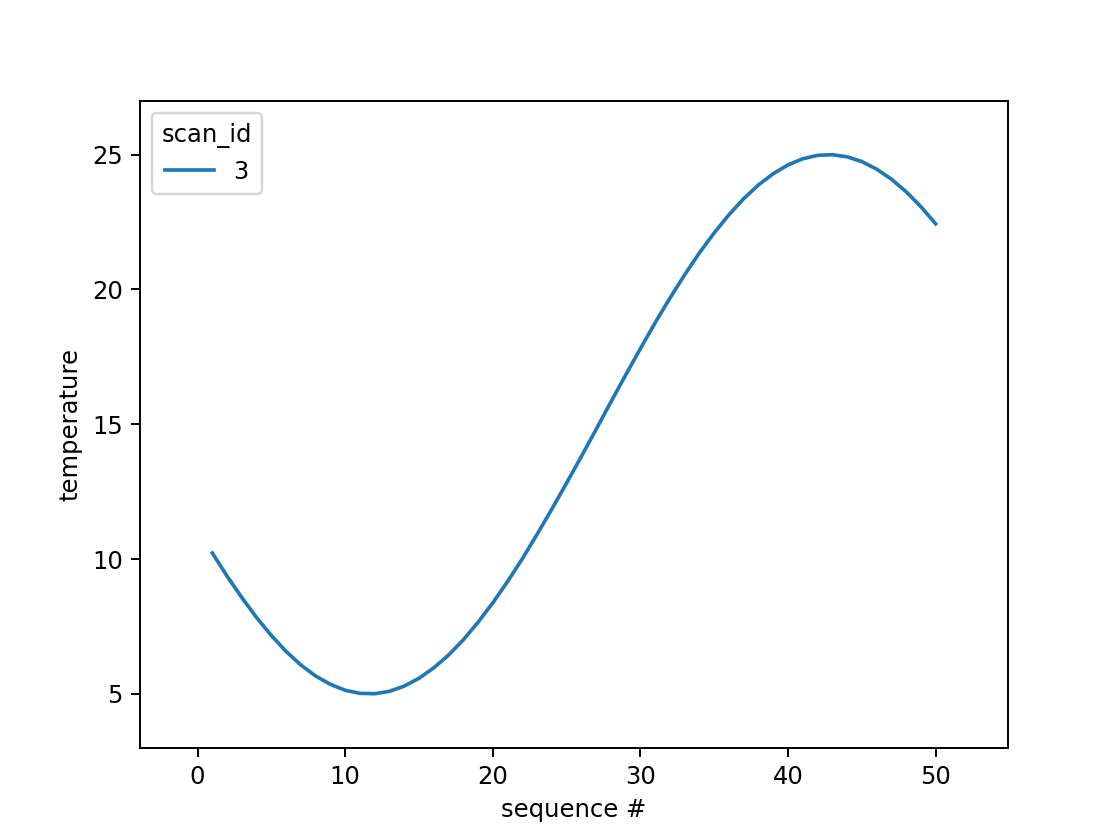

('ac418698-84a2-4fff-a20d-a82edc443241',)

In [7]:
from bluesky.callbacks import LivePlot

RE(bp.count([temperature], num=50, delay=0.1), LivePlot("temperature"))

In [8]:
from typing import List

from bluesky.preprocessors import monitor_during_decorator, suspend_decorator
from bluesky.suspenders import SuspendWhenOutsideBand

def my_experiment(
        start: float, 
        stop: float, 
        steps: int, 
        min_temp: float, 
        max_temp: float):
    suspender = SuspendWhenOutsideBand(temperature, min_temp, max_temp)

    @suspend_decorator([suspender])
    @monitor_during_decorator([temperature])
    def do_scan():
        return (yield from bp.scan([det], x, start, stop, steps))

    return (yield from do_scan())


Subscription value callback exception (SynPeriodicSignal(name='temperature', value=7.2655726046825, timestamp=1664809320.3598819))
Traceback (most recent call last):
  File "/home/vid18871/projects/presentations/bluesky-talk/venv/lib/python3.8/site-packages/ophyd/ophydobj.py", line 492, in inner
    cb(*args, **kwargs)
  File "/home/vid18871/projects/presentations/bluesky-talk/venv/lib/python3.8/site-packages/bluesky/suspenders.py", line 145, in __call__
    raise RuntimeError("Could not create the ")
RuntimeError: Could not create the 


<IPython.core.display.Javascript object>


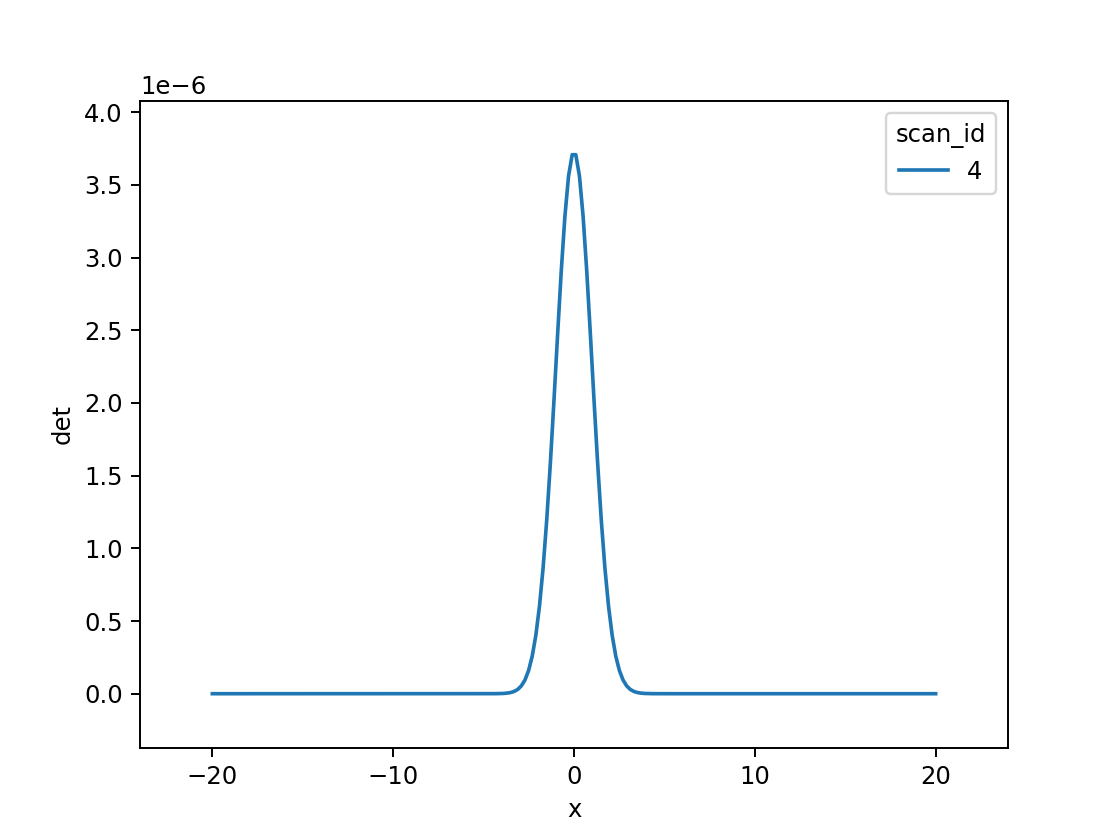

Suspending....To get prompt hit Ctrl-C twice to pause.
Suspension occurred at 2022-10-03 16:02:04.
Justification for this suspension:
Signal temperature = 22.933232592672343 is outside of the range (10.0, 22.0)
Suspender SuspendWhenOutsideBand(SynPeriodicSignal(name='temperature', value=18.377357001065295, timestamp=1664809325.4143195), sleep=0, pre_plan=None, post_plan=None,tripped_message=) reports a return to nominal conditions. Will sleep for 0 seconds and then release suspension at 2022-10-03 16:02:05.
Suspending....To get prompt hit Ctrl-C twice to pause.
Suspension occurred at 2022-10-03 16:02:08.
Justification for this suspension:
Signal temperature = 8.594009095102486 is outside of the range (10.0, 22.0)
Suspender SuspendWhenOutsideBand(SynPeriodicSignal(name='temperature', value=13.698820349508724, timestamp=1664809328.7699544), sleep=0, pre_plan=None, post_plan=None,tripped_message=) reports a return to nominal conditions. Will sleep for 0 seconds and then release suspension

('3adfab05-bde7-4384-9ba9-8ef6507d286b',)

In [9]:
RE(my_experiment(-20., 20., 200, 10., 22.), LivePlot("det", "x"))

## Comparison with Diamond's Data Collection System

- GDA
- Java application with a Jython interpreter for scripting
- GUIs
- Scannables and detectors

<img src="img/gda.png" width="1000"/>

## Why are we Interested in Bluesky?

- Jython no longer supported
- Restricted to Python 2
- Hard to maintain a hybrid application, may be better to have a clean cut between Java and Python code
- Hardware triggered scanning

## Bluesky-as-a-Service

- Controlled via Message Bus
- Takes commands and emits events
- Easy to add new plans

<img src="img/service.svg" width="800"/>

Would like to be able to write

```python
def my_special_plan(detectors: List[Readable], motor: Movable, number_of_iterations: int = 3):
    ...
```

And have it automatically converted to an endpoint

#### Prototyping Work
- NSLS-II: https://github.com/bluesky/bluesky-queueserver
- DLS: https://github.com/callumforrester/blueapi